<a href="https://colab.research.google.com/github/cfont03/Anomaly-breast-cancer-detection/blob/main/src/train/notebooks/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Data Upload

In [ ]:
# Mount google drive
import zipfile
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Access and unzip images
!unzip "/content/gdrive/MyDrive/99_Output/all-mias.zip" -d "/"
print("DONE!")

Archive:  /content/gdrive/MyDrive/99_Output/all-mias.zip
replace /content/archive/all-mias/mdb205.pgm? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
DONE!


In [ ]:
# Importation of libraries
from tensorflow import keras 
print("Keras version   : ", keras.__version__)

%tensorflow_version 2.x
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Multiply, Flatten, Input,
     Dense, Dropout, Conv2D, BatchNormalization, MaxPooling2D, ReLU, LeakyReLU)
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Model
from tensorflow.keras import regularizers
from tensorflow.keras.activations import linear
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K

%pylab inline
import cv2
import glob
import os
import matplotlib.pylab as plt

#from PIL import Image
import PIL.Image
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image
from keras.preprocessing import image as kp_image
#from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
#import tensorflow_addons as tfa

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error

import seaborn as sns
from matplotlib import patches

from google.colab.patches import cv2_imshow
import time
import math

from pathlib import Path

Keras version   :  2.8.0
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['uniform', 'subplots', 'resize', 'array', 'partition', 'pad', 'copy', '__version__', 'random', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# read csvs files from Data Cleansing
train = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_train.csv", sep = ";")
print('Training dataset: \n', train.head())

test = pd.read_csv("/content/gdrive/MyDrive/99_Output/images_preprocess_test.csv", sep = ";")
print('Testing dataset: \n', test.head())

Training dataset: 
    Unnamed: 0    name               features          size   cat  x_coord  \
0           0  mdb058  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  MISC    318.0   
1           1  mdb130  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  ARCH    220.0   
2           2  mdb223  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    591.0   
3           3  mdb240  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    643.0   
4           4  mdb212  [0 0 0 0 ... 0 0 0 0]  (1024, 1024)  CALC    687.0   

   y_coord  radius                            image path   xmin   xmax   ymin  \
0    665.0      27  /content/archive/all-mias/mdb058.pgm  291.0  345.0  638.0   
1    472.0      28  /content/archive/all-mias/mdb130.pgm  192.0  248.0  444.0   
2    495.0       6  /content/archive/all-mias/mdb223.pgm  585.0  597.0  489.0   
3    410.0      23  /content/archive/all-mias/mdb240.pgm  620.0  666.0  387.0   
4    142.0       3  /content/archive/all-mias/mdb212.pgm  684.0  690.0  139.0   

    ymax  
0  692.0  
1  500.0

In [ ]:
df = train
image = 'mdb158.pgm'
path = '/content/archive/all-mias/{:}'.format(image)
im = cv2.imread(path)
xmin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,9]
xmax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,10]
ymin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,11]
ymax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,12]
#xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
print(xmin, xmax, ymin, ymax)

22    452.0
Name: xmin, dtype: float64 22    628.0
Name: xmax, dtype: float64 22    371.0
Name: ymin, dtype: float64 22    547.0
Name: ymax, dtype: float64


In [ ]:
# show boundary box to image
def boundary_box (df):
  
  '''

  This function plots an image with its boundary boxes

  Params:
  1: name image
  8: path image
  9: min coord x
  10: max coord x
  11: min coord y
  12: max coord y

  '''

  image = input("introduce image name: ") 
  path = '/content/archive/all-mias/{:}'.format(image)
  im = cv2.imread(path)
  
  # generate x, y, width and height
  xmin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,9]
  xmax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,10]
  ymin = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,11]
  ymax = df[df['image path'].apply(lambda x : x == str(Path(path)))].iloc[:,12]
  
  xmin, xmax, ymin, ymax = (xmin.values[0], xmax.values[0], ymin.values[0], ymax.values[0])
  width = xmax - xmin
  height = ymax - ymin

  # Create figure and axes
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(im)

  # Create a Rectangle patch
  rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='b', facecolor='none')

  # Add the patch to the Axes
  ax.add_patch(rect)

  plt.show()

introduce image name: mdb160.pgm


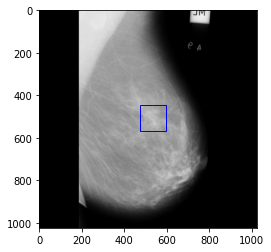

In [ ]:
boundary_box(train)

#1. Preprocess

In [ ]:
# keep interesting fields
train_ = train.iloc[:, [8, 9, 10, 11, 12]]
train_['height'] = 1024
train_['weight'] = 1024
train_['cat'] = train['cat']
train_.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,image path,xmin,xmax,ymin,ymax,height,weight,cat
493,/content/archive/all-mias/mdb207_rotate.jpeg,490.07969,433.511147,543.819805,433.511147,1024,1024,SPIC
494,/content/archive/all-mias/mdb207_hflip.jpeg,434.00000,472.000000,441.000000,479.000000,1024,1024,SPIC
495,/content/archive/all-mias/mdb207_vflip.jpeg,552.00000,590.000000,545.000000,583.000000,1024,1024,SPIC
496,/content/archive/all-mias/mdb207_noise.jpeg,552.00000,590.000000,441.000000,479.000000,1024,1024,SPIC
497,/content/archive/all-mias/mdb207_mask.pgm,552.00000,590.000000,441.000000,479.000000,1024,1024,SPIC


In [ ]:
# resizing input images to fit into pretrained model, to extract features
def resize (df, h = 448, w = 448):
  
  '''

  Function returns resized images to specified size. Format: df
  Default is 448 x 448.

  Params:
  0: image path
  1: xmin
  2: xmax
  3: ymin
  4: ymax
  5: height original image
  6: weight original image
  7: label

  '''

  paths = []
  xmins = []
  xmaxs = []
  ymins = []
  ymaxs = []
  labels = []

  for i in df.iloc:
    img = cv2.imread(str(i[0]))
    img = cv2.resize(img, dsize = (h,w), interpolation = cv2.INTER_CUBIC)
    path, filename_ext = os.path.split(i[0])
    filename = os.path.basename(i[0]).split('.')[0]
    new_path = Path(str(path)+'/{:}_resize{:}'.format(filename, '.jpeg')) # generate new path
    status = cv2.imwrite(str(new_path), img)
    print("Image written to file-system " , new_path,  " :", status) # check if saved
    paths.append(new_path)

    x_factor = w / i[5]
    y_factor = h / i[6]

    # adapt bounding box accordingly
    xmin = i[1] * x_factor
    xmins.append(xmin)
    xmax = i[2] * x_factor
    xmaxs.append(xmax)
    ymin = i[3] * y_factor
    ymins.append(ymin)
    ymax = i[4] * y_factor
    ymaxs.append(ymax)

    labels.append(i[7])

  arr = np.array([paths, xmins, xmaxs, ymins, ymaxs, labels], dtype = object).T.tolist()
  df_ = pd.DataFrame(data = arr, columns = ['image path', 'xmin', 'xmax', 'ymin', 'ymax', 'labels'])
  
  return df_

In [ ]:
# apply to df
train_re = resize(train_, 448, 448)

Image written to file-system  /content/archive/all-mias/mdb058_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb130_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb223_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb240_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb212_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb134_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb005_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb186_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb239_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb165_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb178_resize.jpeg  : True
Image written to file-system  /content/archive/all-mias/mdb171_resize.jpeg  : True
Imag

In [ ]:
train_re.head()

,image path,xmin,xmax,ymin,ymax,labels
0,/content/archive/all-mias/mdb058_resize.jpeg,127.3125,150.9375,279.1250,302.7500,MISC
1,/content/archive/all-mias/mdb130_resize.jpeg,84.0000,108.5000,194.2500,218.7500,ARCH
2,/content/archive/all-mias/mdb223_resize.jpeg,255.9375,261.1875,213.9375,219.1875,CALC
3,/content/archive/all-mias/mdb240_resize.jpeg,271.2500,291.3750,169.3125,189.4375,CALC
4,/content/archive/all-mias/mdb212_resize.jpeg,299.2500,301.8750,60.8125,63.4375,CALC


#2. YOLO implementation

##2.1. Bounding boxes relative to cell grid

Since we are not interested in the classification part of the abnormality but to identify the area, we are going to use only one class. Furthermore, coordinates (x,y) are relative to the image but not the each cell grid. According to the original paper, we have a 7x7 cell grid (S x S). Therefore, we have to convert each coordinate relative to each cell grid.

In [ ]:
from posixpath import join
def boundary_box(df, S = 7, B = 2, C = 20):

  ''' 
  This function adds two boundary boxes relative to image and to cell grid, as well as label matrix.

  Args: df with following params:
  0: image path
  1: x min of boundary box
  2: x max of boundary box
  3: y min of boundary box
  4: y max of boundary box

  Returns: df with added columns in [c, x, y, w, h] format

  '''

  # ---- boundary box relative to image -----
  bbox_img, bbox_cells = [], []
  
  for z in df.iloc: # for each image
    img = cv2.imread(str(z[0])) # read image
    size_w, size_h, _ = img.shape
    x = (z[2] + z[1])/2
    y = (z[4] + z[3])/2
    w = z[2] - z[1]
    h = z[4] - z[3]
    

    bbox_img.append([1, x, y, w, h]) # we only have 1 class to classify
    
    x_ = float(x / size_h)
    y_ = float(y / size_w)

    
  # ---- add bbox relative to cell grid --------
  for box in bbox_img:
    label_matrix = np.zeros((S, S, C + B * 5))
    c, x, y, w, h = box[0], box[1], box[2], box[3], box[4]

    i, j = int(S * y_), int(S * x_) # i, j represent the cell row and column positions the label belongs to
    x_cell, y_cell = x / size_w, y / size_h
    w_cell, h_cell = w / size_w, h / size_h
  
    if label_matrix[i, j, C] == 0: # if no value has been found for i,j ==> restricted to one object per cell
      label_matrix[i, j, C] = 1
      bbox_cell = [x_cell, y_cell, w_cell, h_cell] 
      label_matrix[i, j, C+1:C+5] = bbox_cell
      label_matrix[i, j, c] = 1
    
    
    bbox_cells.append(label_matrix)

  df['bbox_cxywh_img'] = bbox_img
  df['bbox_cywh_cell'] = bbox_cells

  df = df.iloc[:,[0,6,7]]

  return df

In [ ]:
train_re1 = boundary_box(train_re, 7, 1, 1) # apply to dataset
train_re1.head(3)

,image path,bbox_cxywh_img,bbox_cywh_cell
0,/content/archive/all-mias/mdb058_resize.jpeg,"[1, 139.125, 290.9375, 23.625, 23.625]","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0..."
1,/content/archive/all-mias/mdb130_resize.jpeg,"[1, 96.25, 206.5, 24.5, 24.5]","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0..."
2,/content/archive/all-mias/mdb223_resize.jpeg,"[1, 258.5625, 216.5625, 5.25, 5.25]","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0..."


##2.2. Extract coordinates

In [ ]:
def coord_cells (df):

  '''

  This function obtains an array with the coordinates of the boxes relative to the image and relative to the cell

  Args: df containing:

  0: image path
  1: true values relative to the image
  2: true values relative to the cell

  Returns: 
    two arrays

  '''

  img_values = np.array(df.iloc[:,1])
  cell_values = np.array(df.iloc[:,2])

  img_list = np.zeros((len(df.iloc[:,1]), 1, len(df.iloc[:,1].values[0])))
  cell_list = np.zeros((len(df.iloc[:,2]), len(df.iloc[:,2].values[0]), len(df.iloc[:,2].values[0][0]), len(df.iloc[:,2].values[0][0][0]))) # generate empty np                                                                                                  
  
  # replace null values with values
  layer1 = 0
  for i in img_values:
    img_list[layer1, :] = i
    
    layer1 += 1

  
  # repeat process for labels
  layer1 = 0
  for i in cell_values:
    layer2 = 0
    for z in i:
      cell_list[layer1, layer2, :] = z

      layer2 += 1
    
    layer1 += 1


  return img_list, cell_list

In [ ]:
img_list, cell_list = coord_cells(train_re1) # apply to our df

In [ ]:
# check shapes
img_list.shape, cell_list.shape

((498, 1, 5), (498, 7, 7, 6))

##2.3. Convolutional Neural Network - YOLO Architecture

In [ ]:
def yolo_grid(c = 3, S = 7, C = 1, B = 1):

  '''

  This function implements yolo model architecture and outputs a feature vector of 7 x 7 x 30 per image passed, which corresponds to the S x S grid.


  '''

  # show execution time
  start_time = time.time()

  w = h = 448 # input size needs to be 448
  input_img = Input(shape = (w, h, c)) # define input image size
  true_box = Input(shape = (7,7,6))

  # ------ build neural network ------------

  # 24 convolutional layers

  # ---- feature extractor ----
  # block 1
  # layer1
  x = Conv2D(64, kernel_size = (7,7), strides = (2,2), padding = 'same', kernel_initializer = 'normal', name = 'cl1')(input_img)
  x = BatchNormalization(name='norm_1')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_1')(x)
  x = MaxPooling2D((2,2), strides = (2,2), name = 'mpl1')(x)

  # block 2
  # layer2
  x = Conv2D(192, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl2')(x)
  x = BatchNormalization(name='norm_2')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_2')(x)
  x = MaxPooling2D((2,2), strides = (2,2), name = 'mpl2')(x)

  # block 3
  # layer3
  x = Conv2D(128, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl3')(x)
  x = BatchNormalization(name='norm_3')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_3')(x)
  # layer4
  x = Conv2D(256, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl4')(x)
  x = BatchNormalization(name='norm_4')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_4')(x)
  # layer5
  x = Conv2D(256, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl5')(x)
  x = BatchNormalization(name='norm_5')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_5')(x)
  # layer6
  x = Conv2D(512, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl6')(x)
  x = BatchNormalization(name='norm_6')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_6')(x)
  x = MaxPooling2D((2,2), strides = (2,2), name = 'mpl3')(x)

  # block 4
  # layer7
  x = Conv2D(256, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl7')(x)
  x = BatchNormalization(name='norm_7')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_7')(x)
  # layer8
  x = Conv2D(512, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl8')(x)
  x = BatchNormalization(name='norm_8')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_8')(x)
  # layer9
  x = Conv2D(256, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl9')(x)
  x = BatchNormalization(name='norm_9')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_9')(x)
  # layer10
  x = Conv2D(512, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl10')(x)
  x = BatchNormalization(name='norm_10')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_10')(x)
  # layer11
  x = Conv2D(256, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl11')(x)
  x = BatchNormalization(name='norm_11')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_11')(x)
  # layer12
  x = Conv2D(512, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl12')(x)
  x = BatchNormalization(name='norm_12')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_12')(x)
  # layer13
  x = Conv2D(256, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl13')(x)
  x = BatchNormalization(name='norm_13')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_13')(x)
  # layer14
  x = Conv2D(512, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl14')(x)
  x = BatchNormalization(name='norm_14')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_14')(x)
  # layer15
  x = Conv2D(512, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl15')(x)
  x = BatchNormalization(name='norm_15')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_15')(x)
  # layer16
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl16')(x)
  x = BatchNormalization(name='norm_16')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_16')(x)
  x = MaxPooling2D((2,2), strides = (2,2), name = 'mpl4')(x)

  # block 5
  # layer17
  x = Conv2D(512, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl17')(x)
  x = BatchNormalization(name='norm_17')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_17')(x)
  # layer18
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl18')(x)
  x = BatchNormalization(name='norm_18')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_18')(x)
  # layer19
  x = Conv2D(512, kernel_size = (1,1), padding = 'same', kernel_initializer = 'normal', name = 'cl19')(x)
  x = BatchNormalization(name='norm_19')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_19')(x)
  # layer20
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl20')(x)
  x = BatchNormalization(name='norm_20')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_20')(x)
  
  # ---- object classifier -----
  # layer21
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl21')(x)
  x = BatchNormalization(name='norm_21')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_21')(x)
  # layer22
  x = Conv2D(1024, kernel_size = (3,3), strides = (2,2), padding = 'same', kernel_initializer = 'normal', name = 'cl22')(x)
  x = BatchNormalization(name='norm_22')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_22')(x)

  # block 6
  # layer23
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl23')(x)
  x = BatchNormalization(name='norm_23')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_23')(x)
  # layer24
  x = Conv2D(1024, kernel_size = (3,3), padding = 'same', kernel_initializer = 'normal', name = 'cl24')(x)
  x = BatchNormalization(name='norm_24')(x)
  x = LeakyReLU(alpha = 0.1, name = 'leaky_re_lu_24')(x)

  # FCN
  # layer1
  x = tf.keras.layers.Flatten()(x)
  x = Dense(4096)(x)
  x = Dropout(0.0)(x)
  x = LeakyReLU(alpha = 0.1)(x)
  
  # layer2
  x = Dense(S * S * (C + B * 5))(x)
  output = Lambda(lambda args: args[0])([x, true_box])

  model = Model(inputs = [input_img , true_box] , outputs = output)
  
  print('\n', model.summary())

  return model

In [ ]:
model_yolo = yolo_grid(3) # RGB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 cl1 (Conv2D)                   (None, 224, 224, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 224, 224, 64  256         ['cl1[0][0]']                    
                                )                                                             

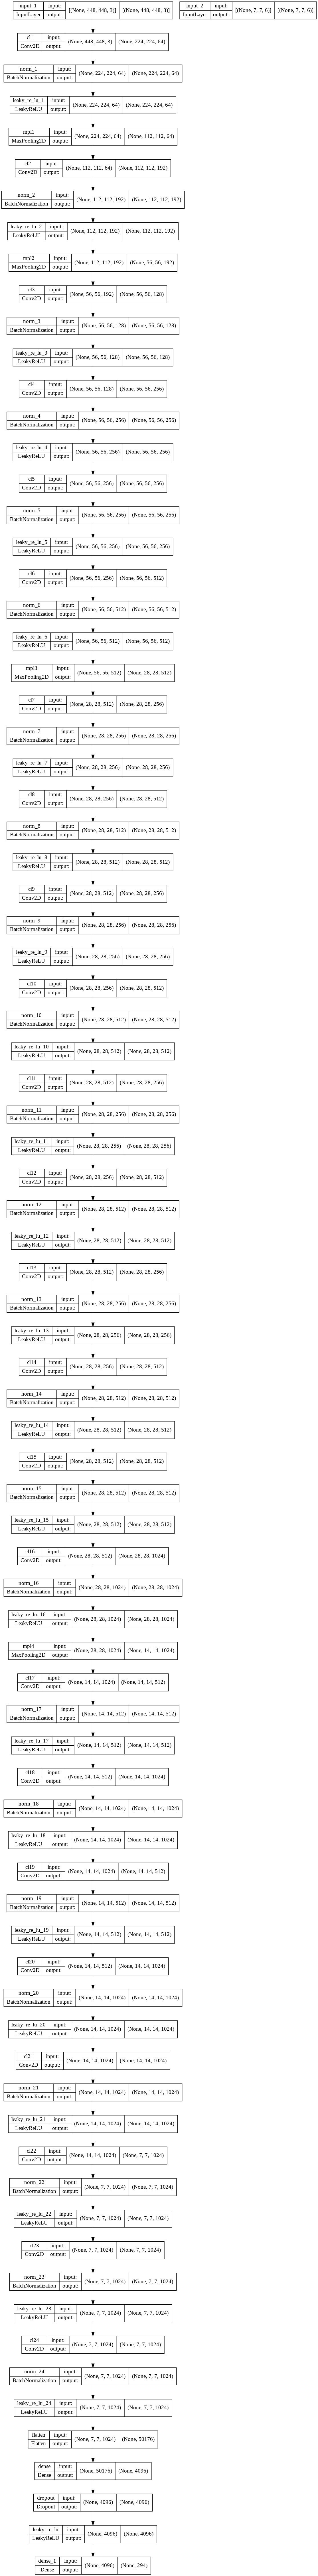

In [ ]:
keras.utils.plot_model(model_yolo, show_shapes=True)

##2.5. Loss function

In [ ]:
def yolo_sse (y_true, y_pred, S=7, B=1, C=1):

      ''' 

      This function implements the sum squared error loss function from the yolo model.  
      Assumption: only one box is predicted by image passed.

      Args: target boxes are in format [c, s, x, y, w, h], where c is the class type and s the confidence score.
            pred boxes are in format [s, x, y, w, h, c]

      Returns: loss value per image

      '''

    # https://blog.emmanuelcaradec.com/humble-yolo-implementation-in-keras/

      coord=5
      noobj=0.5

      true_boxes = K.reshape(y_true[...,2:6], (-1, S * S, B, 4)) # true boxes 
      y_pred = K.reshape(y_pred, (-1, S, S, C + B * 5))
      pred_boxes = K.reshape(y_pred[...,1:5], (-1, S * S, B, 4)) # pred is [score, x,y,w,h, class]
      y_true_conf = K.reshape(y_true[...,1:2], (-1, S * S, B, 1)) # 1_obj of the loss function
      y_true_conf = y_true_conf[...,0]
      
      #print(y_pred)
      #----------- xy loss ----------
      # select xy coordinates
      y_pred_xy   = pred_boxes[...,0:2]
      y_true_xy   = true_boxes[...,0:2]
  
      # calculate xy_loss
      xy_loss = coord * K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)



      #---------- wh loss ------------
      # select wh values
      y_pred_wh   = pred_boxes[...,2:4]
      y_true_wh   = true_boxes[...,2:4]
      
      # calculate loss
      wh_loss = coord *  K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)
      

      #---------- class loss ----------
      # Since we are not interested in the class prediction, the class loss can be ignored
      #y_true_class = y_true[...,0:1]
      #y_true_class = y_true_class[...,0]
      #y_pred_class = y_pred[...,5:6]
      #y_pred_class = y_pred_class[0]
      #print(y_true_class.shape, y_pred_class.shape)
      #clss_loss  = K.sum(K.square(y_true_class - y_pred_class)*y_true_conf, axis=-1)

      #---------- confidence loss -----
      # calculate iou
      intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) )
      intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
      true_area = y_true_wh[...,0] * y_true_wh[...,1]
      pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
      union_area = pred_area + true_area - intersect_area
      iou = intersect_area / union_area
      
      y_pred_conf = K.reshape(y_pred[...,0:1], (-1, S * S, B, 1)) # 1st position indicates the confidence
      y_pred_conf = y_pred_conf[...,0]
      #print('y_pred_conf: ', y_pred_conf)
      #conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf + 1e-6)*y_true_conf, axis=-1)
      conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1) + K.sum(K.square(y_true_conf*iou - y_pred_conf), axis=-1) * noobj
      #print('conf_loss: ', conf_loss[0])
      
      # ---------- total loss ----------
      loss = xy_loss + wh_loss + conf_loss
      loss = K.reshape(loss, (-1, 49, 1, 1))
      
      return loss

## 2.6. Train model

In [ ]:
# convert images into list
train_images = []

for i in train_re.iloc:
    img = cv2.imread(str(i[0]))
    train_images.append(img)

train_images = np.array(train_images)
train_images = train_images/255 # normalize images

In [ ]:
optimizer = Adam(learning_rate = 1e-5)
model_yolo.compile(loss=yolo_sse, optimizer=optimizer, run_eagerly=True)
start_time = time.time()
model_hist = model_yolo.fit([train_images, cell_list], cell_list, epochs = 50) # cell list is y_true
print(f"\n------- Execution time: {(time.time() - start_time)/60:.2f} minutes -------\n")

Epoch 1/50
16/16 [==============================] - 141s 9s/step - loss: 1.1316
Epoch 2/50
16/16 [==============================] - 138s 9s/step - loss: 0.7248
Epoch 3/50
16/16 [==============================] - 137s 9s/step - loss: 0.4690
Epoch 4/50
16/16 [==============================] - 139s 9s/step - loss: 0.3093
Epoch 5/50
16/16 [==============================] - 141s 9s/step - loss: 0.2833
Epoch 6/50
16/16 [==============================] - 138s 9s/step - loss: 0.2219
Epoch 7/50
16/16 [==============================] - 138s 9s/step - loss: 0.1847
Epoch 8/50
16/16 [==============================] - 138s 9s/step - loss: 0.1555
Epoch 9/50
16/16 [==============================] - 143s 9s/step - loss: 0.1459
Epoch 10/50
16/16 [==============================] - 141s 9s/step - loss: 0.1343
Epoch 11/50
16/16 [==============================] - 144s 9s/step - loss: 0.1130
Epoch 12/50
16/16 [==============================] - 145s 9s/step - loss: 0.1057
Epoch 13/50
16/16 [==================

In [ ]:
### CHECKPOINT - SAVE INTO DRIVE
model_yolo.save('/content/archive/model_yolo.h5') # save model
!cp "/content/archive/model_yolo.h5" "/content/gdrive/MyDrive/99_Output"

In [ ]:
print(model_hist.history.keys())

dict_keys(['loss'])


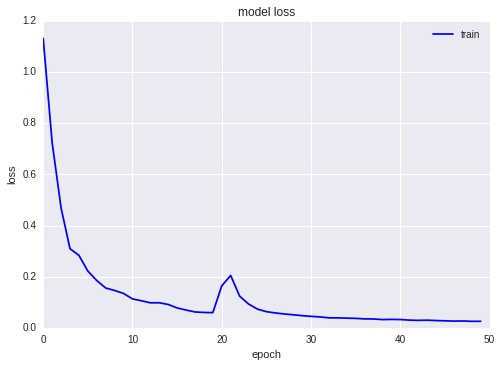

In [268]:
plt.plot(model_hist.history['loss'], 'b')
plt.style.use('seaborn')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

## 2.6. Prediction

In [ ]:
# get the predicted boxes relative to the grid cell
y_pred = model_yolo.predict([train_images, cell_list])

# check output shape
print(y_pred.shape)

(498, 294)


In [ ]:
# reshape to S * S * (B * 5 + C)
S = 7
B = C = 1
y_pred = y_pred.reshape(-1, S, S, B * 5 + C)
print(y_pred.shape)

(498, 7, 7, 6)


Negative values are predicted values outside image range.

##2.7. Convert predicted boxes

We are going to convert the predicted boxes relative to the cell grid back to relative to the image. 

In [ ]:
def cell_to_img(y_pred, S = 7, B = 1, C = 1):

  '''

  This function takes two boundary boxes relative to cell grid and converts them relative to the image

  Args: array of size (x, S, S, B * 5 + C) where x stands for the length of the array

  Returns: np array of size (x, S * S, 4) where x stands for the length of the array
  
  '''

  w_img = h_img = 448 # image size
  batch_size = y_pred.shape[0]
  y_pred = K.reshape(y_pred, (batch_size, S, S, C + B * 5))

  bboxes = y_pred[...,2:6] # output is [c, s, x, y, w, h] where c stands for the class and s for the confidence score
  x, y, w, h = bboxes[...,0:1], bboxes[...,1:2], bboxes[...,2:3], bboxes[...,3:4] 
  s = y_pred[...,1:2]

  #l = np.array(( x - w/2) * w_img, dtype = int)
  #r = np.array(( x + w/2) * w_img, dtype = int)
  #t = np.array(( y - h/2) * h_img, dtype = int)
  #b = np.array(( y + h/2) * h_img, dtype = int)

  l = np.array(x * w_img + 448/2, dtype = int) # recentre from 0 to 1/2 img size
  r = np.array(y * h_img + 448/2, dtype = int)
  t = np.array(w * w_img, dtype = int)
  b = np.array(h * h_img, dtype = int)
  

  #l[l < 0] = l[l < 0] + 448/2
  #r[r > w_img] = w_img - 1
  #t[t < 0] = t[t < 0] * -1
  #b[b < 0] = b[b < 0] * -1

  y_pred_img = np.concatenate((s, l, r, t, b), axis = -1)
  
  return y_pred_img

In [ ]:
y_pred_img = cell_to_img(y_pred, B = 1, C = 1) # convert predicted boxes relative to grid to relative to image

introduce image name: mdb160_resize.jpeg


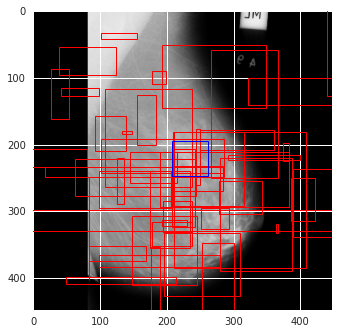

In [ ]:
# plot image as example
image = input("introduce image name: ") 
path = '/content/archive/all-mias/{:}'.format(image)
img = cv2.imread(path)
  

idx = (train_re1[train_re1['image path'].apply(lambda x : x == (Path(path)))].iloc[:,1].index)[0]


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
i_ = idx
xmin = img_list[i_][0][1] - img_list[i_][0][3]/2
ymin = img_list[i_][0][2] - img_list[i_][0][4]/2
rect = patches.Rectangle((xmin, ymin), img_list[i_][0][3], img_list[i_][0][4], linewidth=1, edgecolor='b', facecolor='none')

y_pred_img_ = K.reshape(y_pred_img, (-1, S * S, 5))

for i in y_pred_img_[i_]:
  xmin = i[1] - int(i[3]/2)
  ymin = i[2] - int(i[4]/2)
  rect_ = patches.Rectangle((xmin, ymin), i[3], i[4], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect_)

# Add the patch to the Axes
ax.add_patch(rect)
plt.style.use('classic')
plt.show()

##2.8. Intersection over Union (IoU)

We are going to calculate the IoU between the predicted and the real box of the image.

In [ ]:
def IoU_yolo(box1, box2):

  ''' 
    
  This function calculates the Intersection Over Union between two passed boxes.

  Args:
  box1: first box to compare with [c,x,y,w,h] c = 0:1, x = 1:2, y = 2:3, w = 3:4, h = 4:5 y_true
  box2: second box to compare with [s, x,y,w,h] s = 0:1, x = 1:2, y = 2:3, w = 3:4, h = 4:5 y_pred
  
  Returns a value between 0 and 1

  '''

  # ------calculate coordinate of overlapping region------
  
  # calculate xmin, xmax, ymin and ymax
  xmin_b1 = box1[..., 1:2] - (box1[..., 3:4])/2
  ymin_b1 = box1[..., 2:3] - (box1[..., 4:5])/2
  xmax_b1 = box1[..., 1:2] + (box1[..., 3:4])/2
  ymax_b1 = box1[..., 2:3] + (box1[..., 4:5])/2

  xmin_b2 = tf.cast(box2[..., 1:2], tf.float64) - (box2[..., 3:4])/2
  ymin_b2 = tf.cast(box2[..., 2:3], tf.float64) - (box2[..., 4:5])/2
  xmax_b2 = tf.cast(box2[..., 1:2], tf.float64) + (box2[..., 3:4])/2
  ymax_b2 = tf.cast(box2[..., 2:3], tf.float64) + (box2[..., 4:5])/2
  
  
  # take max of x1 and y1 out of both boxes
  x1 = np.maximum(xmin_b1, xmin_b2)
  y1 = np.maximum(ymin_b1, ymin_b2)
  # take min of x2 and y2 out of both boxes
  x2 = np.maximum(xmax_b1, xmax_b2)
  y2 = np.maximum(ymax_b1, ymax_b2)

  
  # ------area of overlapping region------
  #for a,b,c,d in zip(x1, x2, y1, y2): # if they don't overlap at all
    #if (a > b and c > d):
     # area_overlap = 0
  if (x1[0] < x2[0] and y1[0] < y2[0]):
    area_overlap = 0
  else:
    #width_overlap = np.clip((x2 - x1), 0, 9999)
    width_overlap = x2 - x1
    #height_overlap = np.clip((y2 - y1), 0, 9999)
    height_overlap = y2 - y1
    area_overlap = width_overlap * height_overlap
  
  

  # ------computing union------
  # sum of area of both the boxes - area_overlap
            
  # height and width of both boxes
  width_b1 = box1[...,3:4]
  height_b1 = box1[...,4:5]
  width_b2 = box2[...,3:4]
  height_b2 = box2[...,4:5]


            
  # area of box1 and box2
  area_b1 = tf.cast((width_b1 * height_b1), tf.float64)
  area_b2 = tf.cast((width_b2 * height_b2), tf.float64)
  
  
  # union (including 2 * overlap area (double count))
  area_union_overlap = area_b1 + area_b2
  
  # union
  area_union = area_union_overlap - area_overlap
            
  # compute IOU
  iou = area_overlap/(area_union + 1e-6) # to avoid inf values
  
  #if iou > 1:
   # iou = 0
  #elif iou < 0:
   # iou = 0
  #else:
  #  pass

  return iou

In [ ]:
# check shapes to be compared
img_list.shape, y_pred_img.shape

((498, 1, 5), (498, 7, 7, 5))

In [ ]:
# reshape them
img_list_ = K.reshape(img_list, (-1, 1, 5))
y_pred_img_ = K.reshape(y_pred_img, (-1, 49, 5))

In [ ]:
# one image has one box, but predicted images predicted up to 49 boxes

ious = np.zeros((498 * 49)) # up to 49 iou results for 498 images
#ious_idx = np.zeros((498, 49)) # idxs of the ious

layer1 = 0

for grid_t, grid_pred in zip(img_list_, y_pred_img_):
  #for t, p in zip(grid_t, grid_pred):
  for t in grid_t: # we only have 1 true box
    for p in grid_pred: # 49 predicted boxes
      iou = IoU_yolo(t, p)
      #iou = K.reshape(iou, -1)
      ious[layer1] = iou
      
      layer1 += 1

In [ ]:
# reshape ious
ious = ious.reshape(498, 49, 1)

##2.9. Evaluation of the model

*   TP = predicted boxes with IoU > 0.5
*   FP = predicted boxes with 0 < IoU < 0.5
*   FN = no box is predicted for a ground truth
*   TN = unpredicted background objects => irrelevant


In [ ]:
scores = np.zeros((498, 7 * 7, 1))

threshold = 0.5

l1 = 0
for image in ious:
  l2 = 0
  for grid in image:
    for iou in grid:
      if threshold <= iou <= 1:
        scores[l1, l2, :] = 2 # positive: FG
      elif 0 < iou < threshold:
        scores[l1, l2, :] = 1 # negative: BG
      else:
        pass
    l2 +=1
  l1 +=1

In [ ]:
print('TP: Positive predicted values (foregrounds): ', len(scores[scores == 2]), '/', f'{len(scores[scores == 2]) / len(scores.reshape(-1)): .2%}')
print('FP: Negative predicted values (backgrounds): ', len(scores[scores == 1]), '/', f'{len(scores[scores == 1]) / len(scores.reshape(-1)): .2%}')
print('Total predicted values: ', len(scores.reshape(-1)))

TP: Positive predicted values (foregrounds):  1154 /  4.73%
FP: Negative predicted values (backgrounds):  2960 /  12.13%
Total predicted values:  24402


In [ ]:
print('Correctly predicted boxes out of total predictions: ', f'{len(scores[scores == 2]) / len(scores.reshape(-1)):.2%}')

Correctly predicted boxes out of total predictions:  4.73%


In [174]:
# check which image indexes actually have at least one roi with a positive label (iou > 0.5)
img_boxs = {}

idx_img = 0
for img in scores:
  idx_box = 0
  for score in img:
    if score == 2:
      img_boxs.update({idx_img:idx_box})
      print("idx_img: ", idx_img)
      print("idx_box: ", idx_box)
    else:
      pass
    idx_box +=1
  idx_img +=1

idx_img:  0
idx_box:  17
idx_img:  0
idx_box:  41
idx_img:  0
idx_box:  43
idx_img:  1
idx_box:  7
idx_img:  1
idx_box:  13
idx_img:  1
idx_box:  29
idx_img:  1
idx_box:  43
idx_img:  2
idx_box:  24
idx_img:  2
idx_box:  31
idx_img:  2
idx_box:  48
idx_img:  3
idx_box:  12
idx_img:  3
idx_box:  16
idx_img:  3
idx_box:  41
idx_img:  3
idx_box:  42
idx_img:  4
idx_box:  14
idx_img:  4
idx_box:  39
idx_img:  5
idx_box:  31
idx_img:  5
idx_box:  41
idx_img:  6
idx_box:  32
idx_img:  7
idx_box:  4
idx_img:  7
idx_box:  9
idx_img:  7
idx_box:  43
idx_img:  7
idx_box:  47
idx_img:  8
idx_box:  17
idx_img:  8
idx_box:  31
idx_img:  8
idx_box:  43
idx_img:  9
idx_box:  12
idx_img:  9
idx_box:  20
idx_img:  10
idx_box:  42
idx_img:  10
idx_box:  43
idx_img:  10
idx_box:  48
idx_img:  11
idx_box:  20
idx_img:  11
idx_box:  44
idx_img:  12
idx_box:  3
idx_img:  12
idx_box:  9
idx_img:  12
idx_box:  24
idx_img:  12
idx_box:  34
idx_img:  12
idx_box:  37
idx_img:  14
idx_box:  0
idx_img:  14
idx_box

In [ ]:
img_boxs

image:  /content/archive/all-mias/mdb160_resize.jpeg


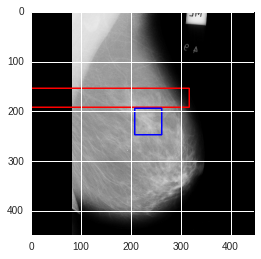

In [266]:
# visualizing foreground proposals
img = 60
box = 20
img_path = Path(train_re.iloc[img,0])
img_ = cv2.imread(str(img_path))

rois = y_pred_img_[img][box][1:5]
bbox_list = img_list[img][0][1:5]

print("image: ", img_path)

for i in range(len(rois)): 
    # visualizing foreground proposals
    x_min = int(rois[0])# - rois[2]/2)
    y_min = int(rois[1])# - rois[3]/2)
    x_max = int(rois[2])# + rois[2]/2)
    y_max = int(rois[3])# + rois[3]/2)
    cv2.rectangle(img_, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=2) 

# plot ground truth
cv2.rectangle(img_, (int(bbox_list[0] - bbox_list[2]/2), int(bbox_list[1] - bbox_list[3]/2)), 
              (int(bbox_list[0] + bbox_list[2]/2), int(bbox_list[1] + bbox_list[3]/2)), color=(0, 0, 255), thickness=2)


plt.imshow(img_)
plt.show()

###2.9.1. Recall

In [ ]:
tp = len(scores[scores == 2])
fp = len(scores[scores == 1])
fn = len(scores[scores == 0])

recall = tp / (tp + fn)

print('Recall: ', f'{recall:.2%}')

Recall:  5.38%


###2.9.2. Precision

In [ ]:
precision = tp / (tp + fp)

print('Precision: ', f'{precision:.2%}')

Precision:  28.05%


###2.9.3. mAP

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
def compute_precision_recall(ious, thresholds):

    '''
    This function calculates the precision_recall curve

    '''

    precisions = []
    recalls = []
    # loop over each threshold
    for threshold in thresholds:
        
        scores = np.zeros((498, 7 * 7, 1))

        l1 = 0
        for image in ious:
          l2 = 0
          for grid in image:
            for iou in grid:
              if threshold <= iou <= 1:
                scores[l1, l2, :] = 2 # positive: FG
              elif 0 < iou < threshold:
                scores[l1, l2, :] = 1 # negative: BG
              else:
                pass
            l2 +=1
          l1 +=1

        
        
        tp = len(scores[scores == 2])
        fp = len(scores[scores == 1])
        fn = len(scores[scores == 0])

        # compute precision and recall for each threshold
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
  
        # append precision and recall for each threshold to
        # precisions and recalls list
        precisions.append(np.round(precision, 3))
        recalls.append(np.round(recall, 3))

    return precisions, recalls

In [ ]:
precisions, recalls = compute_precision_recall(ious, thresholds)

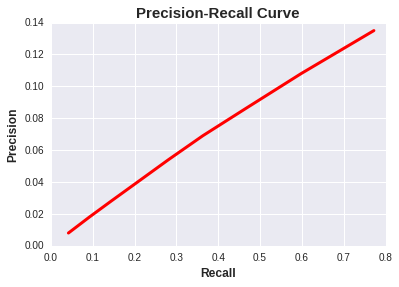

In [267]:
# plot result
plt.plot(precisions, recalls, linewidth=3, color="red")
plt.style.use('seaborn')
plt.xlabel("Recall", fontsize=12, fontweight='bold')
plt.ylabel("Precision", fontsize=12, fontweight='bold')
plt.title("Precision-Recall Curve", fontsize=15, fontweight="bold")
plt.show()